# Introduction

This exercise addresses how to deal with the MODFLOW 6 Observation (OBS) Utility. The OBS utility provides options for extracting numeric values of interest generated during a model run (i.e. "observations").

Observations are output at the end of each time-step and represent the value used by MODFLOW 6 during the time-step. Types of available observations are listed in the MODFLOW6 manual. Commonly used observations are heads, concentrations (for mass transport models) and flows through boundary conditions.

The OBS utility can record outputs to either text or binary files. Text files are written in CSV format, making them easy to access using common spredsheet software or libraries (i.e. Pandas or Numpy).

In this exercise we will:
 - configure observations of flow through the RIV boundary condition
 - define observations of heads at specified locations in the model
 - run the model and access simulated observation data using the .output method

In [18]:
# Import necessary libraries
# for the purposes of this course we are using frozen versions of flopy to avoid depenecy failures.  
import os 
import sys
sys.path.append('../dependencies/')
import flopy
import numpy as np
import matplotlib.pyplot as plt

# Build a Model
The following cell constructs the same model developed in exercise 1 with some modification. A few changes have been introduced:

 - One additional stress period is added to the TDIS package;
 - The new stress period is simulated under transient conditions for 365 days with 12 time-steps.

In [19]:
# simulation
sim_name = 'symple_ex06'
exe_name = os.path.join('..','bin', 'mf6.exe')
workspace = os.path.join('..','models','symple_ex06')

sim = flopy.mf6.MFSimulation(sim_name=sim_name,
                            exe_name=exe_name,
                            version="mf6", 
                            sim_ws=workspace)

Change the TDIS perioddata.

In [20]:
# THis time we will add an extra stress period with a perlen=365 days and nstp=12
perioddata = [(1.0, 1, 1.0), 
                (365, 12, 1.0)] # an additional stress period has been added

# the number of periods (nper) should match the number of tuples in the perioddata list
nper = len(perioddata)

# tdis
time_units = 'days'
tdis = flopy.mf6.ModflowTdis(sim, pname="tdis",
                                  nper=nper, 
                                  perioddata=perioddata, 
                                  time_units=time_units)

With the exception of the RIV, WEL and STO packages, the rest remains the same for now. 
Because we are adding a transient stress period we also need to include the storage (STO) package.
We also add the WEL package, with two wells pumping during the transient stress peroid. This is so that we see some change in our observations. Otherwise it would be boring.


In [21]:
# model
model_name = 'symp06'
gwf = flopy.mf6.ModflowGwf(sim,
                            modelname=model_name,
                            save_flows=True, print_flows=True)
# ims pacakge
ims = flopy.mf6.ModflowIms(sim,
                            pname="ims",
                            complexity="SIMPLE",
                            linear_acceleration="BICGSTAB",)
sim.register_ims_package(ims, [gwf.name])

# dis package
length_units = "METERS"
nlay = 3
Lx = 1000
Ly = 1500
delr = 100 #row length
delc = 100 #column length
ncol = int(Lx/delc)
nrow = int(Ly/delr)
top = 50
botm = [40, 35, 0]

dis = flopy.mf6.ModflowGwfdis(
                            gwf,
                            nlay=nlay,
                            nrow=nrow,
                            ncol=ncol,
                            delr=delr,
                            delc=delc,
                            top=top,
                            botm=botm)

# IC package
strt = np.full((nlay, nrow, ncol), top)
ic = flopy.mf6.ModflowGwfic(gwf, pname="ic", strt=strt)

# NPF package
k = [5, 0.1, 10]
icelltype = [1, 0, 0]

npf = flopy.mf6.ModflowGwfnpf(gwf, icelltype=icelltype, k=k,
                              save_flows=True, 
                              save_specific_discharge=True)

# RCH package
recharge = 50/1000/365
rcha = flopy.mf6.ModflowGwfrcha(gwf, pname='rch', recharge=recharge)

# construct the WEL package
wel_spd = {
            0:[],
            1:[((2, 5, 3), -100), ((2, 10, 6), -50)]
            }
wel = flopy.mf6.ModflowGwfwel(gwf, stress_period_data=wel_spd,
                                    print_input=True, 
                                    print_flows=True,
                                    save_flows=True)


# OC package
# the name of the binary head file
headfile = f"{gwf.name}.hds"
head_filerecord = [headfile]
# the name of the binary budget file
budgetfile = f"{gwf.name}.cbb"
budget_filerecord = [budgetfile]

# which outputs are crecored to the binary files
saverecord = [("HEAD", "ALL"), ("BUDGET", "ALL")]
# which outputs are printed in the list file
printrecord = [("HEAD", "LAST")]
oc = flopy.mf6.ModflowGwfoc(gwf,
                            saverecord=saverecord,
                            head_filerecord=head_filerecord,
                            budget_filerecord=budget_filerecord,
                            printrecord=printrecord)

## **Adding the STO package**

We will take the oportunity to introduce how to specify transient stress periods with the STO package. For this exercise we will simulate the frst stress period as steady state, followed by a transient stress period. 

These are defined using the "steady_state" and "transient" arguments when constructing the STO packge. These arguments take a list or dictionary of booleans (True/False). If a dictionary is passed, the dictionary keys refer to the stress period number (zero-based). Either steadystate or transient conditions will apply until a subsequent stress period is specified as bineg of the other type.

In [22]:
ss = nlay * [1e-5]
sy = nlay * [0.2]

sto = flopy.mf6.ModflowGwfsto(gwf,
                                steady_state={0:True}, 
                                transient={1:True},
                                iconvert = [1, 0, 0],
                                ss=ss, 
                                sy=sy,
                                save_flows=True)

## **Adding Observations to a Stress Package**

Observations can be set for any package using the package.obs object (for example: riv.obs). 

Observations can be specifed on a cell-by-cell basis or for groups of cells using "boundnames" when specifying list data. For things such as boundary conditions, the latter is likley to be a more common use case (i.e. you are morel likley to want to record the flow through all RIV cells rather than for each individual cell). 

Each observation also represents a unique column of data recorded in the output CSV file. So if you are monitoring every cell, such a file can get very large very quickly. Writting the file also slows down model run-times. 

We will go through both options in this exercise.

In [23]:
# Start by specifying the same inputs as in previous exercises
# RIV package
riv_row = 7
stage = top - 5
rbot = botm[0]
cond = 0.1 * delr*delc/1

# Now, when specifyin the list data a new value "river_bc" is added to the tuple. This is a string defining the "boundname". 
# Think of it as a tag for all the cells which make up this river boundary condition.
riv_spd = []
for col in range(ncol):
    riv_spd.append(((0, riv_row, col), stage, cond, rbot, 'river_bc'))


# note that to use boundamens, the "boundnames" argument in the riv package is set to True.
riv = flopy.mf6.ModflowGwfriv(gwf,
                                stress_period_data=riv_spd,
                                boundnames=True)

The next step is to build the observation data dictionary. The dictionary key is the filename of the output file. We shall record our observations to the file "riv_obs.csv". The dictionary value is a list of tuples with the contents of the OBS package's continuous block (see MF6 manual). Each tuple in the list is comprised of (the output file column header, the observation type, the boundname or cellid).

We will record RIV obsservations assocaited to the "river_bc" boundname to "riv_obs.csv". We will add an additional observation to the same output file for a RIV observations at a single cell. Then we will add a second output file ("riv_obs2.csv") with observations from another cell.

In [24]:
# build the observation data dictionary
riv_obs = {
            "riv_obs.csv": [("river", "RIV", "river_bc"), ("riv_7_9", "RIV", (0, 7, 9))],
            "riv_obs2.csv": [("riv_7_0", "RIV", (0, 7, 0))]
            }

In [25]:
# we can then initialize the observations
riv.obs.initialize(digits=10, 
                    print_input=False,
                    continuous=riv_obs)

## **Adding Observations of State Variables**

Model outputs of heads, concentrations and flows between cells are not associated to any specific package. These are assigned in the same manner, but using *flopy.mf6.ModflowUtlobs()* for the OBS Utility.

In the example below we will specify observations at two cells, one in each layer. We will record both head and drawdown.

In [26]:
# as before, first we construct the observation data dictionary and lists
hd_obs_list = [
                ('h_0_7_4', 'HEAD', (0, 7, 4)), # head in the upper aquifer
                ('h_2_7_4', 'HEAD', (2, 7, 4)), # head in the lower aquifer
                ]

dd_obs_list = [
                ('dd_0_7_4', 'DRAWDOWN', (0, 7, 4)), # drawdown in the upper aquifer
                ('dd_2_7_4', 'DRAWDOWN', (2, 7, 4)), # drawdown in the lower aquifer
                ]


obs_data = {
            'head_obs.csv':hd_obs_list,
            'drawdown_obs.csv':dd_obs_list,
            }

In [27]:
# then we initialize the OBS utility pacakge
# initialize obs package
obs_package = flopy.mf6.ModflowUtlobs(gwf, 
                                      digits=10, 
                                      print_input=False,
                                      continuous=obs_data)

## **Write the Model Files and Run**
Write the model files. You can compare them to those in the exercise 01 folder to see how they have changed.

In [28]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model symp06...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package rch...
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 2 based on size of stress_period_data
    writing package oc...
    writing package sto...
    writing package riv_0...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 10 based on size of stress_period_data
    writing package obs_0...
    writing package obs_1...
FloPy is using the following  executable to run the model: ..\bin\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.2.1 02/18/2021

   MODFLOW 6 compiled Feb 18 2021 08:24:05 with IFORT compiler (ver. 19.10.2)

This software has be

(True, [])

# **Access Output Observations**

Model outputs have been written to CSV's in the model workspace folder. These can be accessed as you would any CSV file. 

Alternatively you can use FloPy's .output method as shown below.

In [29]:
# check how many obs pacakges are in the model
print(f'Number of obs packages: {len(gwf.obs)}')

Number of obs packages: 2


In [30]:
# access a list of observation ouput file names of the firs OBS package
gwf.obs[0].output.obs_names

['riv_obs.csv', 'riv_obs2.csv']

In [31]:
# access a list of observation ouput file names of the second OBS package
gwf.obs[1].output.obs_names

['head_obs.csv', 'drawdown_obs.csv']

In [32]:
# load the output obsevration csv by referencing the file name
riv_obs_csv = gwf.obs[0].output.obs(f='riv_obs.csv')

# access a recarray of the observation data with
riv_obs_csv.data

rec.array([(  1.        , -205.5162359 , -20.55064817),
           ( 31.41666667, -175.5626117 , -19.03731715),
           ( 61.83333333, -158.1785763 , -17.76890749),
           ( 92.25      , -145.0744799 , -16.66133965),
           (122.66666667, -134.4598181 , -15.69454821),
           (153.08333333, -125.5059045 , -14.8458321 ),
           (183.5       , -117.7677195 , -14.09621838),
           (213.91666667, -110.9832541 , -13.43094113),
           (244.33333333, -104.9861642 , -12.83869259),
           (274.75      ,  -99.66088497, -12.31052518),
           (305.16666667,  -94.92024738, -11.8390684 ),
           (335.58333333,  -90.69420584, -11.41804706),
           (366.        ,  -86.92400923, -11.04199775)],
          dtype=[('totim', '<f8'), ('RIVER', '<f8'), ('RIV_7_9', '<f8')])

In [33]:
# you can then manipulate or plot that data as desired. Personaly I find Pandas dataframes easier to handle
import pandas  as pd
obs_df = pd.DataFrame(riv_obs_csv.data)

obs_df.head()

,totim,RIVER,RIV_7_9
0,1.000000,-205.516236,-20.550648
1,31.416667,-175.562612,-19.037317
2,61.833333,-158.178576,-17.768907
3,92.250000,-145.074480,-16.661340
4,122.666667,-134.459818,-15.694548


<AxesSubplot:xlabel='totim'>

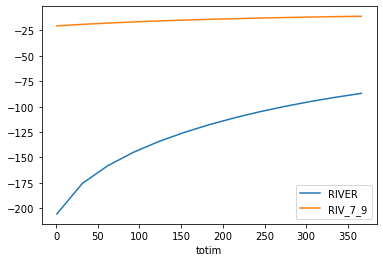

In [34]:
# a quick and dirty plot
obs_df.plot(x='totim')